# 导入原始数据

In [349]:
import pandas as pd
import numpy as np

train = pd.read_csv('D:\\githubProject\\house-prices-advanced-regression-techniques\\train.csv')
test = pd.read_csv('D:\\githubProject\\house-prices-advanced-regression-techniques\\test.csv')

# 认识数据（探索特征变量与结果变量之间的关系）

In [350]:
import seaborn as sns
print('训练数据集的大小是：{}'.format(train.shape))
print(train.info())

训练数据集的大小是：(1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exteri

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
LowQualFinSF     0.025606
Id               0.021917
MiscVal          0.021190
BsmtHalfBath     0.016844
BsmtFinSF2       0.011378
Name: SalePr

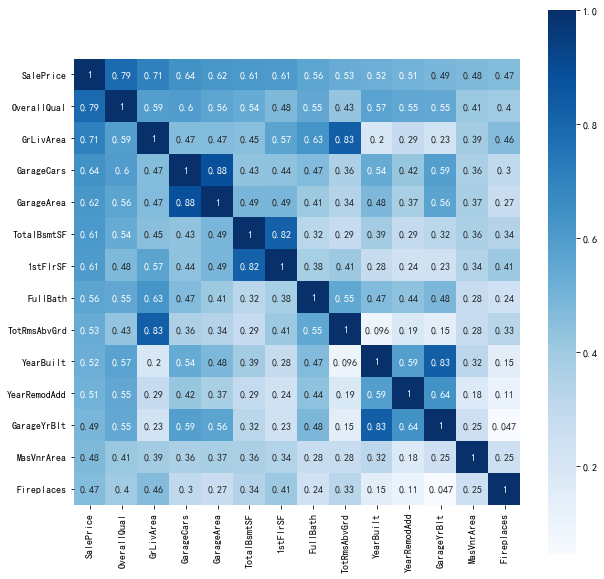

In [351]:

#做相关度排序，记录前三个相关度最大的变量（后续可做离群点分析），记录相关度低于0.2的变量（后续可考虑删除？）
corr_saleprice = abs(train.corr(method='pearson')['SalePrice']).sort_values(ascending=False)
corr_top3 = corr_saleprice.index[1:4]
corr_last = corr_saleprice[corr_saleprice<0.2].index
print(corr_saleprice)
print('corr_top3:{}\ncorr_last:{}'.format(corr_top3,corr_last))

#取相关度大于40%的变量话相关矩阵热力图（彼此相关度大的特征后续二选一或者做特征组合）
#特征变量中相关度比较大的是(GrLivArea地面居住面积，TotRmsAbvGrd总房间数)(GarageCars车库容量大小,GarageArea车库大小)(TotalBsmtSF,1stFlrSF一楼面积)(YearBuilt原施工日期,GarageYrBlt车库建成年)
import matplotlib.pyplot as plt
corr_top_40procent = corr_saleprice[corr_saleprice>0.4].index
corr_heatmap = train[corr_top_40procent].corr()
plt.subplots(figsize=(10, 10))
sns.heatmap(corr_heatmap,annot=True, vmax=1, square=True, cmap="Blues")

Int64Index([523, 1298], dtype='int64')


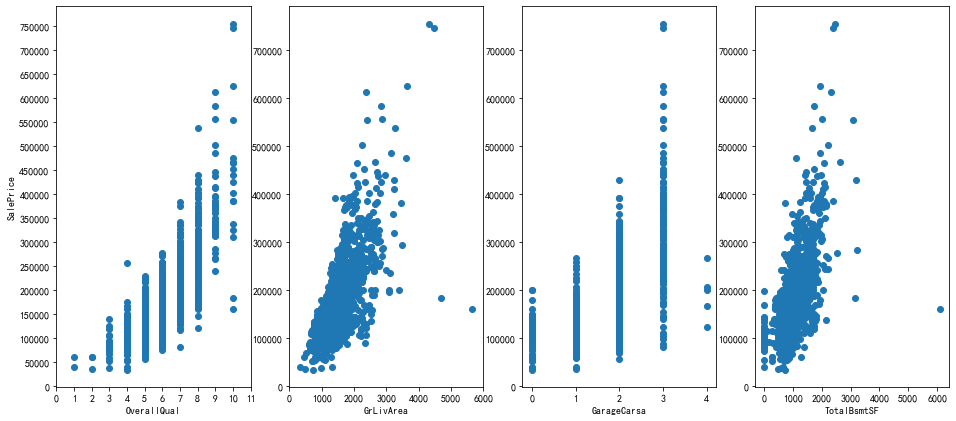

In [352]:
#离群点分析（画散点图）
plt.figure(figsize=(16,7))
ax1=plt.subplot(141)
ax1.scatter(y=train['SalePrice'],x=train['OverallQual'])
ax1.set_ylabel('SalePrice')
ax1.set_xlabel('OverallQual')
ax1.set_xticks(range(0,12,1))
ax1.set_yticks(range(0,800000,50000))

ax2=plt.subplot(142)
ax2.scatter(y=train['SalePrice'],x=train['GrLivArea'])
ax2.set_xlabel('GrLivArea')
ax2.set_xticks(range(0,7000,1000))

ax3=plt.subplot(143)
ax3.scatter(y=train['SalePrice'],x=train['GarageCars'])
ax3.set_xlabel('GarageCarsa')
ax3.set_xticks(range(0,5,1))

ax4=plt.subplot(144)
ax4.scatter(y=train['SalePrice'],x=train['TotalBsmtSF'])
ax4.set_xlabel('TotalBsmtSF')
ax4.set_xticks(range(0,7000,1000))

#记录离群点的记录id,数据清洗时可以直接删掉
error_values = train[((train['GrLivArea']>4000) & (train['SalePrice']<200000))|(train['TotalBsmtSF']>5000)].index
print(error_values)

# 清洗数据（删除离群点、缺失值填补）

In [353]:
#删除离散点，并拼接训练集和测试集
for i in error_values:
    train.drop(i,inplace=True)
Y = train.pop('SalePrice')
data_all = pd.concat([train,test],axis=0)
data_all.drop('Id',axis=1,inplace=True)
print(data_all.shape)

(2917, 79)


In [354]:
#判断类目型特征变量及数值型特征变量
data_dtypes = data_all.dtypes
feats_cata = data_dtypes[data_dtypes==object].index#类目型
feats_num = data_dtypes[data_dtypes!=object].index#数值型，但里面混入了类目型数据，特征工程环节再做进一步区分

In [356]:
#查看数据缺失情况
missing_sorted = (data_all.isnull().sum()).sort_values(ascending = False)
missing = missing_sorted[missing_sorted>0]
not_missing = missing_sorted[missing_sorted==0]
len(missing)


34

# 特征工程方式一

In [357]:
#特征工程方式二


#清洗数据
data_all['PoolQC']=data_all['PoolQC'].fillna('None')
#data_all['PoolQC']=data_all['PoolQC'].replace({'Ex':4,'Gd':3,'TA':2,'Fa':1,'None':0})
data_all['MiscFeature']=data_all['MiscFeature'].fillna('None')
#data_all['MiscFeature']=data_all['MiscFeature'].replace({'Elev':1,'Gar2':1,'Othr':1,'Shed':1,'TenC':1})
data_all['Alley']=data_all['Alley'].fillna('None')
data_all['Fence']=data_all['Fence'].fillna('None')
data_all['FireplaceQu']=data_all['FireplaceQu'].fillna('None')
data_all['LotFrontage']=data_all['LotFrontage'].fillna(data_all['LotFrontage'].median())
data_all['GarageYrBlt']=data_all['GarageYrBlt'].fillna(data_all['GarageYrBlt'].min()-1)


for i in ['GarageCond','GarageQual','GarageFinish','GarageType']:
    data_all[i]=data_all[i].fillna('None')
    
for i in ['BsmtCond','BsmtExposure','BsmtQual','BsmtFinType2','BsmtFinType1']:
    data_all[i]=data_all[i].fillna('None')

data_all['MasVnrType']=data_all['MasVnrType'].fillna('None')
data_all['MasVnrArea']=data_all['MasVnrArea'].fillna(0)

for i in ['MSZoning','BsmtHalfBath','Utilities','SaleType','KitchenQual','GarageCars','Electrical','Functional','BsmtFullBath','Exterior1st','Exterior2nd']:
    data_all[i]=data_all[i].fillna(data_all[i].mode()[0])

for i in ['BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','BsmtUnfSF','GarageArea']:
    data_all[i]=data_all[i].fillna(data_all[i].median())
    
data_all.isnull().sum().sort_values(ascending = False)



SaleCondition    0
Foundation       0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
BsmtQual         0
YearRemodAdd     0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
RoofStyle        0
YearBuilt        0
Heating          0
Utilities        0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
LotConfig        0
                ..
ScreenPorch      0
GarageFinish     0
PoolArea         0
PoolQC           0
Fence            0
MiscFeature      0
MiscVal          0
MoSold           0
YrSold           0
GarageCars       0
GarageYrBlt      0
CentralAir       0
FullBath         0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
HalfBath         0
GarageType  

In [358]:
#类目型特征数值化,类目间不强调等级

from sklearn.preprocessing import LabelEncoder
a = ['PoolQC','Fence','Alley','ExterQual','ExterCond','BsmtQual','BsmtCond',
'BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','CentralAir','KitchenQual','FireplaceQu','GarageType'
,'GarageFinish','GarageQual','GarageCond']

b = ['MiscFeature','SaleType','MSSubClass','MSZoning','Street','LotShape',
'LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','BldgType','Condition2','HouseStyle'
,'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation','Heating','Electrical','Functional',
'PavedDrive','SaleCondition']
for i in missing_sorted.index:
    if i in a:
        print(i,data_all[i].unique(),len(data_all[i].unique()))
    elif i in b:
        lbl = LabelEncoder() 
        lbl.fit(list(data_all[i].v
                     \
                     alues))
        data_all[i] = lbl.transform(list(data_all[i].values))
    


PoolQC ['None' 'Ex' 'Fa' 'Gd'] 4
Alley ['None' 'Grvl' 'Pave'] 3
Fence ['None' 'MnPrv' 'GdWo' 'GdPrv' 'MnWw'] 5
FireplaceQu ['None' 'TA' 'Gd' 'Fa' 'Ex' 'Po'] 6
GarageCond ['TA' 'Fa' 'None' 'Gd' 'Po' 'Ex'] 6
GarageQual ['TA' 'Fa' 'Gd' 'None' 'Ex' 'Po'] 6
GarageFinish ['RFn' 'Unf' 'Fin' 'None'] 4
GarageType ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' 'None' 'Basment' '2Types'] 7
BsmtCond ['TA' 'Gd' 'None' 'Fa' 'Po'] 5
BsmtExposure ['No' 'Gd' 'Mn' 'Av' 'None'] 5
BsmtQual ['Gd' 'TA' 'Ex' 'None' 'Fa'] 5
BsmtFinType2 ['Unf' 'BLQ' 'None' 'ALQ' 'Rec' 'LwQ' 'GLQ'] 7
BsmtFinType1 ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'None' 'LwQ'] 7
KitchenQual ['Gd' 'TA' 'Ex' 'Fa'] 4
HeatingQC ['Ex' 'Gd' 'TA' 'Fa' 'Po'] 5
ExterQual ['Gd' 'TA' 'Ex' 'Fa'] 4
ExterCond ['TA' 'Gd' 'Fa' 'Po' 'Ex'] 5
CentralAir ['Y' 'N'] 2


In [359]:
#类目型特征数值化,类目间有明显等级关系
data_all['PoolQC']=data_all['PoolQC'].replace({'Ex':4,'Gd':3,'TA':2,'Fa':1,'None':0})
data_all['Alley']=data_all['Alley'].replace({'Grvl':2,'Pave':1,'None':0})
data_all['Fence']=data_all['Fence'].replace({'GdPrv':4,'MnPrv':3,'GdWo':2,'MnWw':1,'None':0})
data_all['FireplaceQu']=data_all['FireplaceQu'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0})
data_all['GarageCond']=data_all['GarageCond'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0})
data_all['GarageQual']=data_all['GarageQual'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0})
data_all['GarageFinish']=data_all['GarageFinish'].replace({'Fin':3,'RFn':2,'Unf':1,'None':0})
data_all['GarageType']=data_all['GarageType'].replace({'2Types':6,'Attchd':5,'Basment':4,'BuiltIn':3,'CarPort':2,'Detchd':1,'None':0})
data_all['BsmtCond']=data_all['BsmtCond'].replace({'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0})
data_all['BsmtExposure']=data_all['BsmtExposure'].replace({'Gd':4,'Av':3,'Mn':2,'No':1,'None':0})
data_all['BsmtQual']=data_all['BsmtQual'].replace({'Ex':4,'Gd':3,'TA':2,'Fa':1,'None':0})
data_all['BsmtFinType2']=data_all['BsmtFinType2'].replace({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'None':0})
data_all['BsmtFinType1']=data_all['BsmtFinType1'].replace({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'None':0})
data_all['KitchenQual']=data_all['KitchenQual'].replace({'Ex':4,'Gd':3,'TA':2,'Fa':1})
data_all['HeatingQC']=data_all['HeatingQC'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
data_all['ExterQual']=data_all['ExterQual'].replace({'Ex':4,'Gd':3,'TA':2,'Fa':1})
data_all['ExterCond']=data_all['ExterCond'].replace({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
data_all['CentralAir']=data_all['CentralAir'].replace({'Y':1,'N':0})

In [360]:
print(data_all.shape,Y.shape)
print(data_all.dtypes[data_all.dtypes==object])

(2917, 79) (1458,)
Series([], dtype: object)


In [361]:
#无量纲化：归一化处理全部训练数据
from sklearn import preprocessing 
min_max_scaler = preprocessing.MinMaxScaler() 
for i in missing_sorted.index:
    data_all[i] = min_max_scaler.fit_transform(data_all[i].values.reshape(-1, 1)) 

#让训练集的目标变量数据更加平滑
#log1p就是log（1+x)
Y = np.log1p(Y)
print(data_all.shape,Y.shape)



(2917, 79) (1458,)


# 特征工程方式二

In [272]:

feats_number = ['LotFrontage','LotArea','YearBuilt','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','GarageYrBlt','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']
from sklearn.preprocessing import StandardScaler
for i in missing.index:
    if i in feats_number:
        data_all[i] = data_all[i].fillna(data_all[i].median())
        std = StandardScaler()
        x = data_all[i].values
        #将x进行标准化
        x_std = std.fit_transform(x.reshape(-1, 1))
        data_all[i]=x_std
    else:
        data_all[i] = data_all[i].fillna('None')
        dummy_one = pd.get_dummies(data_all[i], prefix=i)
        data_all = pd.concat([dummy_one,data_all],axis=1)
        data_all.drop([i],axis=1,inplace=True)

for j in not_missing.index:
    if j in feats_number:
        std = StandardScaler()
        x = data_all[j].values
        #将x进行标准化
        x_std = std.fit_transform(x.reshape(-1, 1))
        data_all[j]=x_std
    else:
        dummy_one = pd.get_dummies(data_all[j], prefix=j)
        data_all = pd.concat([dummy_one,data_all],axis=1)
        data_all.drop([j],axis=1,inplace=True)
print(data_all.shape)


#让训练集的目标变量数据更加平滑
#log1p就是log（1+x)
Y = np.log1p(Y)

(2917, 462)


In [ ]:

'''
#先填补，后进行类目型属性数值化处理、数值过大的数值型数据scale处理
feats_number = ['LotFrontage','LotArea','YearBuilt','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','GarageYrBlt','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']
for i in missing.index:
    if i in feats_number:
        data_all[i] = data_all[i].fillna(data_all[i].median())
    else:
        data_all[i] = data_all[i].fillna('null')
        
print(data_all.shape)
'''

SalePrice       1.000000
OverallQual     0.821405
GrLivArea       0.725211
ExterQual       0.682226
GarageCars      0.681033
KitchenQual     0.669990
GarageArea      0.656129
BsmtQual        0.649133
TotalBsmtSF     0.647563
1stFlrSF        0.620500
GarageFinish    0.605602
FullBath        0.595899
GarageYrBlt     0.592708
YearBuilt       0.587043
YearRemodAdd    0.565992
FireplaceQu     0.546791
TotRmsAbvGrd    0.537702
GarageType      0.503358
Fireplaces      0.491998
HeatingQC       0.473938
MasVnrArea      0.430570
Foundation      0.412203
BsmtFinSF1      0.392283
GarageQual      0.363257
BsmtExposure    0.358410
GarageCond      0.356765
CentralAir      0.351598
LotFrontage     0.350593
BsmtFinType1    0.335000
WoodDeckSF      0.334251
                  ...   
Heating         0.139911
Functional      0.131350
Exterior2nd     0.126196
Exterior1st     0.122364
ScreenPorch     0.121245
Condition1      0.115675
RoofMatl        0.107536
PoolQC          0.085825
PoolArea        0.074338


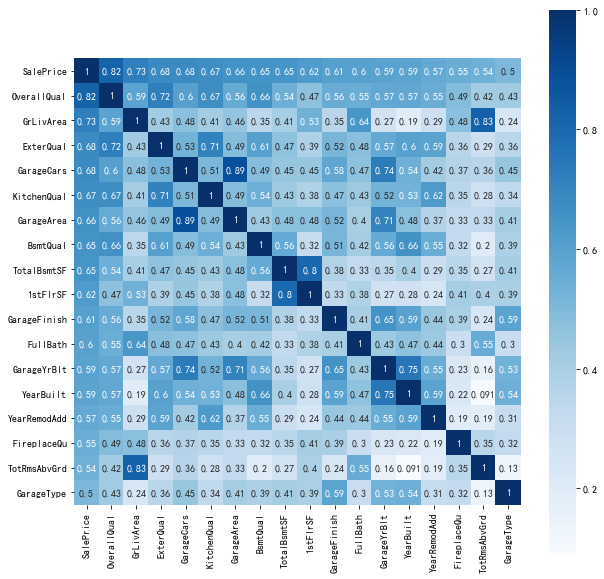

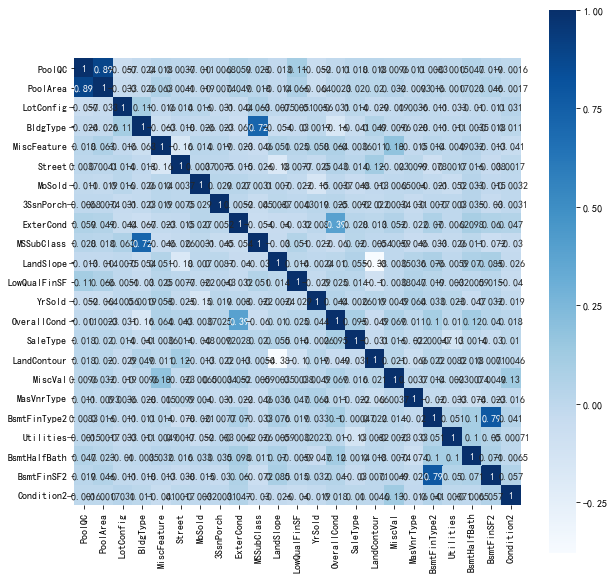

In [397]:
#因变量和自变量相关度分析
corr_data=pd.concat([data_all[:1458],Y],axis=1)
corrs=abs(corr_data.corr()['SalePrice']).sort_values(ascending=False)
print(corrs)
corrs_high_columns=corrs[corrs>0.5].index
corrs_low_columns=corrs[corrs<0.1].index
#高相关变量相关矩阵热图
corrs_high=corr_data[corrs_high_columns].corr()
plt.subplots(figsize=(10,10))
sns.heatmap(corrs_high,annot=True, vmax=1, square=True, cmap="Blues")
plt.show()
#低相关变量相关矩阵热图
corrs_low=corr_data[corrs_low_columns].corr()
plt.subplots(figsize=(10,10))
sns.heatmap(corrs_low,annot=True, vmax=1, square=True, cmap="Blues")
plt.show()

In [ ]:
#离群点分析（画散点图）
plt.figure(figsize=(16,7))
ax1=plt.subplot(141)
ax1.scatter(y=train['SalePrice'],x=train['OverallQual'])
ax1.set_ylabel('SalePrice')
ax1.set_xlabel('OverallQual')
ax1.set_xticks(range(0,12,1))
ax1.set_yticks(range(0,800000,50000))

ax2=plt.subplot(142)
ax2.scatter(y=train['SalePrice'],x=train['GrLivArea'])
ax2.set_xlabel('GrLivArea')
ax2.set_xticks(range(0,7000,1000))

ax3=plt.subplot(143)
ax3.scatter(y=train['SalePrice'],x=train['GarageCars'])
ax3.set_xlabel('GarageCarsa')
ax3.set_xticks(range(0,5,1))

ax4=plt.subplot(144)
ax4.scatter(y=train['SalePrice'],x=train['TotalBsmtSF'])
ax4.set_xlabel('TotalBsmtSF')
ax4.set_xticks(range(0,7000,1000))

#记录离群点的记录id,数据清洗时可以直接删掉
error_values = train[((train['GrLivArea']>4000) & (train['SalePrice']<200000))|(train['TotalBsmtSF']>5000)].index
print(error_values)

# 模型训练

In [362]:
data_train= data_all[:1458]
data_test= data_all[1458:]
print(data_train.shape,data_test.shape)

(1458, 79) (1459, 79)


[0.1360203078338075, 0.13171453424972226]


Text(0.5, 1.0, 'Max Featrues vs cv Error')

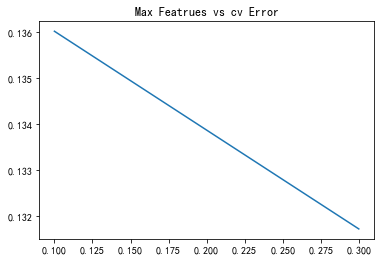

In [367]:
#随机森林模型交叉验证及调参
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

max_features=[.1,.3]
test_scores=[]
for max_feature in max_features:
    clf=RandomForestRegressor(n_estimators=800,max_features=max_feature)
    test_score=np.sqrt(-cross_val_score(clf, data_train, Y, scoring="neg_mean_squared_error", cv = 5))

    test_scores.append(np.mean(test_score))
print(test_scores)
plt.plot(max_features,test_scores)
plt.title("Max Featrues vs cv Error")

[0.11647700519185215, 0.11730255661765368, 0.11971369288075237, 0.11959947874872953]


ValueError: x and y must have same first dimension, but have shapes (2,) and (4,)

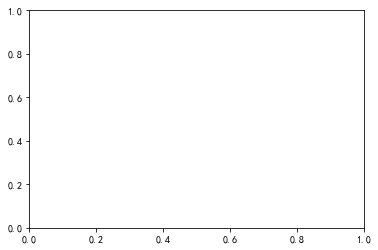

In [372]:
#GradientBoostingRegressor模型调参、交叉验证
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error



max_depths=range(2,10,2)
test_scores=[]
for max_depth_one in max_depths:
    clf = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=max_depth_one, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
    test_score=np.sqrt(-cross_val_score(clf, data_train, Y, scoring="neg_mean_squared_error", cv = 5))
    test_scores.append(np.mean(test_score))
print(test_scores)


In [ ]:
#最优参数下，对模型拟合状态进行评估

In [383]:
from sklearn.model_selection import learning_curve
clf = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
train_sizes,train_score,test_score=learning_curve(clf, data_train, Y, train_sizes=[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],scoring="neg_mean_squared_error", cv = 5)


Text(0.5, 1.0, 'learning_curve')

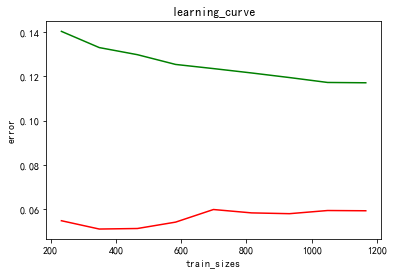

In [384]:
from pylab import mpl
# 使matplotlib模块能显示中文
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
train_error=np.mean(np.sqrt(-train_score),axis=1)
test_error=np.mean(np.sqrt(-test_score),axis=1)
plt.plot(train_sizes,train_error,color='r',label='training')
plt.plot(train_sizes,test_error,color='g',label='testing')
plt.xlabel('train_sizes')
plt.ylabel('error')
plt.title("learning_curve")

In [ ]:
imp = clf.feature_importances_
imp = pd.DataFrame({ 'score': imp},index=train.columns)
 # 按照特征重要性, 进行降序排列, 最重要的特征在最前面
imp = imp.sort_values('score',ascending=False)[:100]
print(imp)

#bivariate analysis saleprice/grlivarea 
#imp.plot(kind='bar', stacked=True)   
alldata_choic=alldata.loc[:,imp.index]
print(alldata_choic.columns)

# 最终模型选定及预测

In [368]:
clf=RandomForestRegressor(n_estimators=1000,max_features=0.3)
clf.fit(data_train,Y)
a=clf.predict(data_test)
rf_pred = np.expm1(a)
save_df = pd.DataFrame({
    'ID' : test.Id,
    'SalePrice' : rf_pred
})
save_df.to_csv('D:\\githubProject\\house-prices-advanced-regression-techniques\\RandomForestRegressor_predict.csv', index=False)

In [398]:
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

for i in corrs_low_columns:
    data_all=data_all.drop(i,axis=1)
data_train= data_all[:1458]
data_test= data_all[1458:]
print(data_train.shape,data_test.shape)

clf = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
clf.fit(data_train,Y)
a=clf.predict(data_test)
rf_pred = np.expm1(a)
save_df = pd.DataFrame({
    'ID' : test.Id,
    'SalePrice' : rf_pred
})
save_df.to_csv('D:\\githubProject\\house-prices-advanced-regression-techniques\\GradientBoostingRegressor_1.csv', index=False)

(1458, 56) (1459, 56)
